In [ ]:
import torch
print('GPU 可用：', torch.cuda.is_available(), '，设备名：', torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


GPU 可用： False ，设备名： None


In [ ]:
# 导入embedding和stock label文件

from google.colab import drive
import torch
drive.mount('/content/drive')

# 2. 指定 .pt 文件路径
pt_path = '/content/drive/My Drive/545 Group/datasets/embeddings_split0.pt'

# 3. 用 torch.load 读取
embeddings = torch.load(pt_path, weights_only=False)

# 查看类型和内容
print(type(embeddings))
try:
    print(embeddings.shape)
except:
    # 如果是 dict 或 list
    print(embeddings.keys() if isinstance(embeddings, dict) else len(embeddings))

Mounted at /content/drive
<class 'list'>
1943232


In [ ]:
# 把embedding转成dataframe

import pandas as pd
import numpy as np

# 构造 DataFrame
df1 = pd.DataFrame({
    'date':      [sample['date'] for sample in embeddings],
    'embedding': [np.asarray(sample['embedding']).tolist() for sample in embeddings]
})

print(df1.shape)  # (194323, 2)
display(df1.head())


(1943232, 2)


,date,embedding
0,2023-12-16 23:00:00 UTC,"[-0.90576171875, -0.751953125, -0.9228515625, ..."
1,2023-12-12 00:00:00 UTC,"[-0.88232421875, -0.423583984375, -0.860839843..."
2,2023-12-12 00:00:00 UTC,"[-0.76904296875, -0.422119140625, -0.766113281..."
3,2023-12-07 00:00:00 UTC,"[-0.79150390625, -0.2430419921875, -0.08081054..."
4,2023-12-07 00:00:00 UTC,"[-0.371826171875, -0.320068359375, -0.9609375,..."


In [ ]:
# 把date 去掉小时分钟和UTC，再加一
df = df1.copy()

# 1) 解析成 datetime 并只保留日期部分
#    去掉末尾 " UTC"，再 parse，最后保留 .dt.date
df['date'] = df1['date'].str[:10]

# 1) 先转成 datetime 类型
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# # 2) 加一天
# df['date'] = df['date'] + pd.Timedelta(days=1)

# 3) 如果你还想把它变回字符串
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

# 2) 把 embedding 列转换成 ndarray
df['emb_arr'] = df['embedding'].apply(np.asarray)

print(df.shape)
display(df.head())

(1943232, 3)


,date,embedding,emb_arr
0,2023-12-16,"[-0.90576171875, -0.751953125, -0.9228515625, ...","[-0.90576171875, -0.751953125, -0.9228515625, ..."
1,2023-12-12,"[-0.88232421875, -0.423583984375, -0.860839843...","[-0.88232421875, -0.423583984375, -0.860839843..."
2,2023-12-12,"[-0.76904296875, -0.422119140625, -0.766113281...","[-0.76904296875, -0.422119140625, -0.766113281..."
3,2023-12-07,"[-0.79150390625, -0.2430419921875, -0.08081054...","[-0.79150390625, -0.2430419921875, -0.08081054..."
4,2023-12-07,"[-0.371826171875, -0.320068359375, -0.9609375,...","[-0.371826171875, -0.320068359375, -0.9609375,..."


In [ ]:
# 查看重复日期数量

# 总行数
total = len(df)

# 不同日期的个数
unique_dates = df['date'].nunique()

# 重复的日期总数
dup_count = total - unique_dates
print(f'总行数: {total}，唯一日期数: {unique_dates}，重复日期条目数: {dup_count}')

# 如果你想看每个日期出现的次数：
counts = df['date'].value_counts()
print(counts)

# 或者直接计算有多少行是重复（只保留第一次出现为非重复）：
dup_rows = df['date'].duplicated().sum()
print(f'使用duplicated()算出的重复行数: {dup_rows}')


总行数: 1943232，唯一日期数: 5089，重复日期条目数: 1938143
date
2023-12-11    47950
2023-12-16    43651
2023-12-12    43420
2023-12-13    26925
2023-12-07    25769
              ...  
2011-10-09        1
2015-08-02        1
2012-07-08        1
2013-03-02        1
2009-12-23        1
Name: count, Length: 5089, dtype: int64
使用duplicated()算出的重复行数: 1938143


In [ ]:
# method1：把每个date分组求平均合并到一个

# 3) 按 date_only 分组，堆叠后求平均
grouped = (
    df
    .groupby('date')['emb_arr']
    .apply(lambda arrs: np.mean(np.stack(arrs.values), axis=0))
    .reset_index()
)

# 4) （可选）把 ndarray 转回 list
grouped['embedding'] = grouped['emb_arr'].apply(lambda x: x.tolist())

# 5) 保留最终两列，并重命名
result = grouped[['date', 'embedding']]

print(result.shape)
display(result.head())

(5089, 2)


,date,embedding
0,2009-04-08,"[-0.89501953125, -0.56689453125, -0.748046875,..."
1,2009-04-14,"[-0.87005615234375, -0.421722412109375, -0.511..."
2,2009-04-21,"[-0.7722981770833334, -0.4353841145833333, -0...."
3,2009-04-27,"[-0.89892578125, -0.40576171875, -0.8012695312..."
4,2009-05-06,"[-0.70849609375, -0.1995849609375, -0.62207031..."


In [ ]:
# 把两个表按日期merge到一起

# 2. 读入标签
stock_path = '/content/drive/My Drive/545 Group/orgi/labeled_stock.csv'

df_labels = pd.read_csv(stock_path, parse_dates=["Date"])

# 把标签表里的 Date 列也格式化成 "YYYY-MM-DD" 字符串，以便跟 result['date'] 对齐
df_labels["date"] = df_labels["Date"].dt.strftime("%Y-%m-%d")
df_labels = df_labels[["date", "label"]]

# 3. 合并：按 date 做 inner join（只保留两边都有的日期）
merged = pd.merge(
    result,         # 你的平均 embeddings 表，含 ['date','embedding']
    df_labels,      # 标签表，含 ['date','label']
    on="date",
    how="inner"     # or how="left" 如果想保留所有 embeddings，即使某些没标签
)

print(merged.shape)   # (对齐后的天数, 3)
display(merged.head())

# 现在 merged 长这样：
#         date        embedding                          label
# 0  2023-12-13  [-0.89, 0.12, …]                           1
# 1  2023-12-14  [ 0.34, -0.56,…]                           2
# …
print(len(merged['embedding'][0]))

(3522, 3)


,date,embedding,label
0,2010-01-04,"[-0.22764078776041666, -0.02825927734375, -0.5...",1
1,2010-01-05,"[0.2423129611545139, 0.31934017605251735, 0.07...",1
2,2010-01-06,"[-0.103271484375, 0.12353515625, 0.015625, 0.0...",1
3,2010-01-07,"[-0.65283203125, -0.2603251139322917, -0.87760...",1
4,2010-01-08,"[-0.4335123697916667, -0.074371337890625, -0.6...",1


768


In [ ]:
!pip install XGBoost

# 随机森林和XGBoost baseline

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble    import RandomForestClassifier
from xgboost             import XGBClassifier
from sklearn.metrics     import accuracy_score, classification_report, confusion_matrix

# 假设 all_embeddings, all_labels 已经准备好
X_train, X_val, y_train, y_val = train_test_split(
    all_embeddings, all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

# ——————————————— Random Forest ———————————————
rf = RandomForestClassifier(
    n_estimators=200,       # 树的数量
    max_depth=None,         # 不限制深度
    class_weight='balanced',# 类别不平衡时加权
    n_jobs=-1,              # 并行加速
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))


# ——————————————— XGBoost ———————————————
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1,     # 若类别极度不平衡可调整
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)

print("\n=== XGBoost ===")
print("Accuracy:", accuracy_score(y_val, y_pred_xgb))
print(classification_report(y_val, y_pred_xgb, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_xgb))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.7 MB/s eta 0:00:00
=== Random Forest ===
Accuracy: 0.5929078014184397
              precision    recall  f1-score   support

           0     0.5301    0.3415    0.4154       284
           1     0.0000    0.0000    0.0000        18
           2     0.6149    0.7965    0.6941       403

    accuracy                         0.5929       705
   macro avg     0.3817    0.3794    0.3698       705
weighted avg     0.5650    0.5929    0.5641       705

Confusion Matrix:
 [[ 97   0 187]
 [  4   0  14]
 [ 82   0 321]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/t


=== XGBoost ===
Accuracy: 0.6
              precision    recall  f1-score   support

           0     0.5359    0.3944    0.4544       284
           1     1.0000    0.0556    0.1053        18
           2     0.6263    0.7692    0.6904       403

    accuracy                         0.6000       705
   macro avg     0.7207    0.4064    0.4167       705
weighted avg     0.5994    0.6000    0.5804       705

Confusion Matrix:
 [[112   0 172]
 [  4   1  13]
 [ 93   0 310]]


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader


# 修改后的数据集类
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        # 保持原始二维结构，在获取数据时动态增加维度
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels,    dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # 返回形状 (1, embed_dim) 的序列
        return self.X[idx].unsqueeze(0), self.y[idx]  # 添加序列维度


all_embeddings = np.vstack(merged['embedding'].values)
#    labels 是 (N,) 的整数数组
all_labels     = merged['label'].to_numpy()

# 举例划分训练和验证集
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    all_embeddings, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_dataset = EmbeddingDataset(X_train, y_train)
val_dataset   = EmbeddingDataset(X_val,   y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)


In [ ]:
# 定义 Transformer 分类模型
import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(self, embed_dim, num_classes,
                 nhead=8, num_layers=2, dim_feedforward=512, dropout=0.1):
        super().__init__()
        # 单层 Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True   # 直接用 (B, S, E) 的输入格式
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # 最后分类用的全连接 多层分类头
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.SiLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 64),
            nn.LayerNorm(64),
            nn.ELU(),
            nn.Dropout(0.2),

            nn.Linear(64, num_classes)
        )


    def forward(self, x):
        # x: (batch_size, seq_len, embed_dim)
        # TransformerEncoder 输出同样维度
        x_enc = self.encoder(x)             # => (B, S, E)
        # 池化：这里取序列上的平均
        x_mean = x_enc.mean(dim=1)          # => (B, E)
        logits = self.classifier(x_mean)    # => (B, num_classes)
        return logits

# 参数示例
embed_dim   = X_train.shape[-1]  # 你的 embedding 维度
hidden_dim1 = 512
hidden_dim2 = 256
hidden_dim3 = 128
num_classes = 3
model = TransformerClassifier(embed_dim, num_classes).to(device)


In [ ]:
# 4. 配置优化器和损失
optimizer = torch.optim.AdamW(
    model.classifier.parameters(),
    lr=1e-3,        # 分类头可用较大学习率
    weight_decay=1e-2
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 加 label smoothing

Epoch 1 val: 100%|██████████| 12/12 [00:00<00:00, 188.47it/s]


[Epoch 1] train_loss: 0.8804  val_loss: 0.8317  val_acc: 0.5887


Epoch 2 val: 100%|██████████| 12/12 [00:00<00:00, 220.00it/s]


[Epoch 2] train_loss: 0.8572  val_loss: 0.8299  val_acc: 0.5957


Epoch 3 val: 100%|██████████| 12/12 [00:00<00:00, 188.31it/s]


[Epoch 3] train_loss: 0.8537  val_loss: 0.8252  val_acc: 0.5844


Epoch 4 val: 100%|██████████| 12/12 [00:00<00:00, 188.96it/s]


[Epoch 4] train_loss: 0.8503  val_loss: 0.8210  val_acc: 0.5915


Epoch 5 val: 100%|██████████| 12/12 [00:00<00:00, 184.02it/s]


[Epoch 5] train_loss: 0.8521  val_loss: 0.8282  val_acc: 0.5844


Epoch 6 val: 100%|██████████| 12/12 [00:00<00:00, 185.55it/s]


[Epoch 6] train_loss: 0.8505  val_loss: 0.8279  val_acc: 0.5801


Epoch 7 val: 100%|██████████| 12/12 [00:00<00:00, 187.90it/s]


[Epoch 7] train_loss: 0.8485  val_loss: 0.8301  val_acc: 0.5844


Epoch 8 val: 100%|██████████| 12/12 [00:00<00:00, 220.93it/s]


[Epoch 8] train_loss: 0.8508  val_loss: 0.8233  val_acc: 0.5915


Epoch 9 val: 100%|██████████| 12/12 [00:00<00:00, 218.40it/s]


[Epoch 9] train_loss: 0.8490  val_loss: 0.8221  val_acc: 0.5943


Epoch 10 val: 100%|██████████| 12/12 [00:00<00:00, 194.29it/s]


[Epoch 10] train_loss: 0.8499  val_loss: 0.8217  val_acc: 0.5858


Epoch 11 val: 100%|██████████| 12/12 [00:00<00:00, 189.47it/s]


[Epoch 11] train_loss: 0.8643  val_loss: 0.8266  val_acc: 0.5887


Epoch 12 val: 100%|██████████| 12/12 [00:00<00:00, 187.87it/s]


[Epoch 12] train_loss: 0.8538  val_loss: 0.8196  val_acc: 0.5844


Epoch 13 val: 100%|██████████| 12/12 [00:00<00:00, 227.25it/s]


[Epoch 13] train_loss: 0.8471  val_loss: 0.8283  val_acc: 0.5773


Epoch 14 val: 100%|██████████| 12/12 [00:00<00:00, 225.96it/s]


[Epoch 14] train_loss: 0.8440  val_loss: 0.8233  val_acc: 0.5943


Epoch 15 val: 100%|██████████| 12/12 [00:00<00:00, 187.20it/s]


[Epoch 15] train_loss: 0.8459  val_loss: 0.8271  val_acc: 0.6014


Epoch 16 val: 100%|██████████| 12/12 [00:00<00:00, 185.86it/s]


[Epoch 16] train_loss: 0.8450  val_loss: 0.8201  val_acc: 0.5972


Epoch 17 val: 100%|██████████| 12/12 [00:00<00:00, 219.02it/s]


[Epoch 17] train_loss: 0.8435  val_loss: 0.8226  val_acc: 0.5915


Epoch 18 val: 100%|██████████| 12/12 [00:00<00:00, 185.75it/s]


[Epoch 18] train_loss: 0.8709  val_loss: 0.8197  val_acc: 0.5957


Epoch 19 val: 100%|██████████| 12/12 [00:00<00:00, 222.92it/s]


[Epoch 19] train_loss: 0.8466  val_loss: 0.8225  val_acc: 0.5929


Epoch 20 val: 100%|██████████| 12/12 [00:00<00:00, 227.22it/s]


[Epoch 20] train_loss: 0.8409  val_loss: 0.8223  val_acc: 0.5844


Epoch 21 val: 100%|██████████| 12/12 [00:00<00:00, 229.84it/s]


[Epoch 21] train_loss: 0.8447  val_loss: 0.8186  val_acc: 0.5887


Epoch 22 val: 100%|██████████| 12/12 [00:00<00:00, 190.47it/s]


[Epoch 22] train_loss: 0.8464  val_loss: 0.8204  val_acc: 0.6000


Epoch 23 val: 100%|██████████| 12/12 [00:00<00:00, 227.04it/s]


[Epoch 23] train_loss: 0.8460  val_loss: 0.8244  val_acc: 0.6000


Epoch 24 val: 100%|██████████| 12/12 [00:00<00:00, 187.46it/s]


[Epoch 24] train_loss: 0.8479  val_loss: 0.8243  val_acc: 0.6028


Epoch 25 val: 100%|██████████| 12/12 [00:00<00:00, 181.57it/s]


[Epoch 25] train_loss: 0.8417  val_loss: 0.8214  val_acc: 0.6085


Epoch 26 val: 100%|██████████| 12/12 [00:00<00:00, 218.69it/s]


[Epoch 26] train_loss: 0.8453  val_loss: 0.8250  val_acc: 0.5844


Epoch 27 val: 100%|██████████| 12/12 [00:00<00:00, 218.80it/s]


[Epoch 27] train_loss: 0.8417  val_loss: 0.8193  val_acc: 0.5972


Epoch 28 val: 100%|██████████| 12/12 [00:00<00:00, 187.87it/s]


[Epoch 28] train_loss: 0.8482  val_loss: 0.8197  val_acc: 0.5986


Epoch 29 val: 100%|██████████| 12/12 [00:00<00:00, 208.76it/s]


[Epoch 29] train_loss: 0.8476  val_loss: 0.8231  val_acc: 0.6043


Epoch 30 val: 100%|██████████| 12/12 [00:00<00:00, 187.15it/s]


[Epoch 30] train_loss: 0.8409  val_loss: 0.8322  val_acc: 0.6170


Epoch 31 val: 100%|██████████| 12/12 [00:00<00:00, 183.59it/s]


[Epoch 31] train_loss: 0.8456  val_loss: 0.8290  val_acc: 0.5972


Epoch 32 val: 100%|██████████| 12/12 [00:00<00:00, 183.53it/s]


[Epoch 32] train_loss: 0.8442  val_loss: 0.8409  val_acc: 0.5957


Epoch 33 val: 100%|██████████| 12/12 [00:00<00:00, 187.09it/s]


[Epoch 33] train_loss: 0.8431  val_loss: 0.8266  val_acc: 0.5943


Epoch 34 val: 100%|██████████| 12/12 [00:00<00:00, 189.44it/s]


[Epoch 34] train_loss: 0.8406  val_loss: 0.8179  val_acc: 0.5957


Epoch 35 val: 100%|██████████| 12/12 [00:00<00:00, 205.53it/s]


[Epoch 35] train_loss: 0.8423  val_loss: 0.8262  val_acc: 0.5887


Epoch 36 val: 100%|██████████| 12/12 [00:00<00:00, 208.97it/s]


[Epoch 36] train_loss: 0.8464  val_loss: 0.8373  val_acc: 0.6057


Epoch 37 val: 100%|██████████| 12/12 [00:00<00:00, 183.94it/s]


[Epoch 37] train_loss: 0.8480  val_loss: 0.8249  val_acc: 0.6043


Epoch 38 val: 100%|██████████| 12/12 [00:00<00:00, 205.13it/s]


[Epoch 38] train_loss: 0.8458  val_loss: 0.8313  val_acc: 0.5943


Epoch 39 val: 100%|██████████| 12/12 [00:00<00:00, 186.48it/s]


[Epoch 39] train_loss: 0.8451  val_loss: 0.8221  val_acc: 0.5972


Epoch 40 val: 100%|██████████| 12/12 [00:00<00:00, 186.79it/s]


[Epoch 40] train_loss: 0.8447  val_loss: 0.8408  val_acc: 0.5986


Epoch 41 val: 100%|██████████| 12/12 [00:00<00:00, 216.79it/s]


[Epoch 41] train_loss: 0.8386  val_loss: 0.8217  val_acc: 0.5986


Epoch 42 val: 100%|██████████| 12/12 [00:00<00:00, 221.28it/s]


[Epoch 42] train_loss: 0.8388  val_loss: 0.8243  val_acc: 0.5929


Epoch 43 val: 100%|██████████| 12/12 [00:00<00:00, 191.29it/s]


[Epoch 43] train_loss: 0.8466  val_loss: 0.8272  val_acc: 0.6057


Epoch 44 val: 100%|██████████| 12/12 [00:00<00:00, 206.69it/s]


[Epoch 44] train_loss: 0.8420  val_loss: 0.8427  val_acc: 0.5972


Epoch 45 val: 100%|██████████| 12/12 [00:00<00:00, 203.94it/s]


[Epoch 45] train_loss: 0.8385  val_loss: 0.8337  val_acc: 0.6085


Epoch 46 val: 100%|██████████| 12/12 [00:00<00:00, 187.91it/s]


[Epoch 46] train_loss: 0.8440  val_loss: 0.8358  val_acc: 0.5986


Epoch 47 val: 100%|██████████| 12/12 [00:00<00:00, 211.56it/s]


[Epoch 47] train_loss: 0.8394  val_loss: 0.8359  val_acc: 0.6028


Epoch 48 val: 100%|██████████| 12/12 [00:00<00:00, 188.34it/s]


[Epoch 48] train_loss: 0.8399  val_loss: 0.8232  val_acc: 0.6028


Epoch 49 val: 100%|██████████| 12/12 [00:00<00:00, 188.98it/s]


[Epoch 49] train_loss: 0.8382  val_loss: 0.8210  val_acc: 0.6057


Epoch 50 val: 100%|██████████| 12/12 [00:00<00:00, 184.36it/s]


[Epoch 50] train_loss: 0.8395  val_loss: 0.8252  val_acc: 0.6170


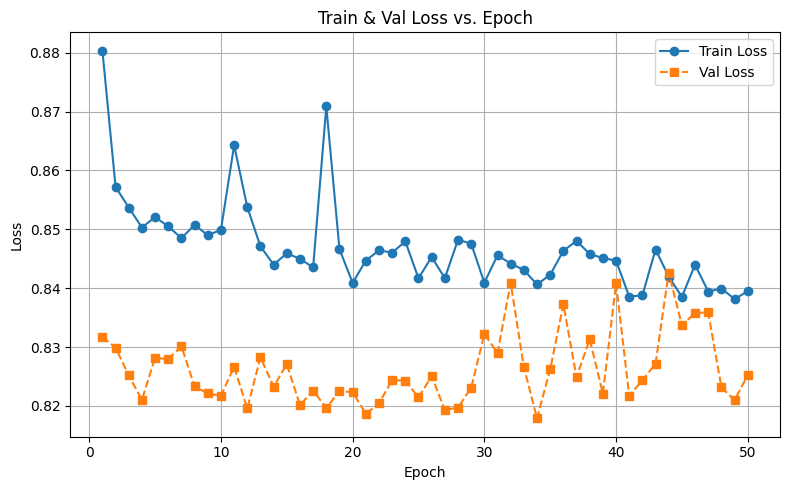

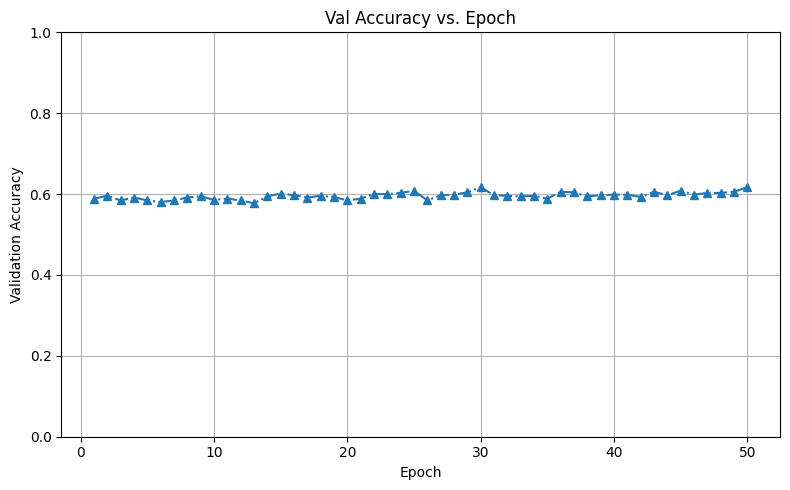

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. 定义存储列表
train_losses = []
val_losses   = []
val_accs     = []

# 2. 训练 + 验证循环
num_epochs = 50
for epoch in range(1, num_epochs+1):
    # —— 训练 ——
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch} train"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # —— 验证 ——
    model.eval()
    total_val_loss = 0
    correct = 0
    total   = 0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch} val"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            total_val_loss += criterion(logits, y_batch).item()
            preds = logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total   += y_batch.size(0)
    avg_val_loss = total_val_loss / len(val_loader)
    val_acc      = correct / total

    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"[Epoch {epoch}] train_loss: {avg_train_loss:.4f}  "
          f"val_loss: {avg_val_loss:.4f}  val_acc: {val_acc:.4f}")

# 3. 画出曲线
epochs = list(range(1, num_epochs+1))

# —— Loss 曲线（Train & Val） ——
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', label='Train Loss')
plt.plot(epochs, val_losses,   marker='s', linestyle='--', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Val Loss vs. Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# —— Val Accuracy 曲线 ——
plt.figure(figsize=(8,5))
plt.plot(epochs, val_accs, marker='^', linestyle='-.')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Val Accuracy vs. Epoch')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()
